In [32]:
"""
LANDFIRE assessments for MODIS and VIIRS AFDs western U.S.

Data sources:
    - LANDFIRE Existing Vegetation Type (EVT) proportional cover
    - LANDFIRE Canopy Bulk Density (CBD) mean
    - LANDIFRE Canopy Base Height (CBH) mean
    - LANDFIRE Canopy Cover (CC) percentage
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [28]:
# Load the combined MODIS and VIIRS AFDs (buffered)
fp = os.path.join(projdir,f'data/spatial/mod/AFD/combined-afd_aspen-fires_2018_to_2023_buffer.gpkg')
afds = gpd.read_file(fp)
afds.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'VID', 'NIFC_ID', 'NIFC_NAME',
       'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'na_l3name',
       'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME', 'afdID', 'geometry'],
      dtype='object')

In [3]:
# Tidy columns for simplicity.
afds_ = afds_[['afdID','START_YEAR','geometry']]
afds_.head()

,afdID,START_YEAR,geometry
0,MODIS7298,2018,"POLYGON ((-1334259.255 1940525.281, -1334259.2..."
1,MODIS7301,2018,"POLYGON ((-1335247.149 1940508.597, -1335247.1..."
2,MODIS7989,2018,"POLYGON ((-1149036.475 2035501.025, -1149036.4..."
3,MODIS7990,2018,"POLYGON ((-1148030.494 2035535.701, -1148030.4..."
4,MODIS7991,2018,"POLYGON ((-1148997.363 2034487.930, -1148997.3..."


### Calculate the Proportional EVT in AFD Observations

From LANDFIRE EVT (ca. 2016) calculate the proportional cover within AFD observations (buffers). Then, identify the dominant vegetation type for each observation.

In [4]:
# Load the EVT raster

In [5]:
evt_fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt_da = rxr.open_rasterio(evt_fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


81

In [6]:
# Crop to fire bounds.
bounds = afds_.total_bounds
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da
gc.collect()

66

In [7]:
t0 = time.time()

# Get the proportional landcover
afds_evt = compute_band_stats(
    geoms=afds_, 
    image_da=evt_da_crop, 
    id_col='afdID'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.42 minutes.

~~~~~~~~~~



In [8]:
afds_evt.head()

,afdID,evt,count,total_pixels,pct_cover
0,MODIS7298,7011,103.0,1190.0,8.655462
1,MODIS7298,7012,306.0,1190.0,25.714286
2,MODIS7298,7016,306.0,1190.0,25.714286
3,MODIS7298,7051,82.0,1190.0,6.890756
4,MODIS7298,7052,171.0,1190.0,14.369748


In [9]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [10]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
afds_evt = afds_evt.merge(lookup, left_on='evt', right_on='VALUE', how='left')
afds_evt.drop('VALUE', axis=1, inplace=True)
afds_evt.head()

,afdID,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,MODIS7298,7011,103.0,1190.0,8.655462,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy
1,MODIS7298,7012,306.0,1190.0,25.714286,Rocky Mountain Bigtooth Maple Ravine Woodland,Hardwood,Bigtooth Maple Woodland,Open tree canopy
2,MODIS7298,7016,306.0,1190.0,25.714286,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy
3,MODIS7298,7051,82.0,1190.0,6.890756,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy
4,MODIS7298,7052,171.0,1190.0,14.369748,Southern Rocky Mountain Mesic Montane Mixed Co...,Conifer,Douglas-fir-Grand Fir-White Fir Forest and Woo...,Closed tree canopy


In [25]:
# Export a table of the values found in AFD observations
lookup_ = lookup[lookup['VALUE'].isin(afds_evt['evt'].unique())]
lookup_.to_csv(os.path.join(projdir,'data/tabular/mod/EVT/afd_evt_codes.csv'))

# Export the zonal statistics table.
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT.csv')
afds_evt.to_csv(out_fp)
print(f"Saved zonal statistics to: {out_fp}")

Saved zonal statistics to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT.csv


In [51]:
print(afds_evt['EVT_PHYS'].unique())

['Hardwood' 'Conifer' 'Conifer-Hardwood' 'Shrubland' 'Grassland'
 'Exotic Herbaceous' 'Developed-Roads' 'Sparsely Vegetated' 'Riparian'
 'Exotic Tree-Shrub' 'Developed-Low Intensity' 'Agricultural' 'Open Water'
 'Developed' 'Developed-Medium Intensity' 'Developed-High Intensity'
 'Quarries-Strip Mines-Gravel Pits-Well and Wind Pads' 'Snow-Ice']


In [ ]:
# Make some plots. Just for the SRM.

In [63]:
# Join back to FRP

frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']

evt = afds_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]

frp_evt_srm = pd.merge(frp, evt, on='afdID', how='left')
frp_evt_srm.head()

,afdID,INSTRUMENT,ACQ_DATETIME,DAYNIGHT,FRP,na_l3name,EVT_NAME,EVT_PHYS,EVT_GP_N,pct_cover
0,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,14.446367
1,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,0.519031
2,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",36.505190
3,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Inter-Mountain Basins Big Sagebrush Shrubland,Shrubland,Big Sagebrush Shrubland and Steppe,0.259516
4,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Rocky Mountain Lower Montane-Foothill Shrubland,Shrubland,Deciduous Shrubland,0.432526


In [64]:
# Create a "pct_forest" class
forest_classes = ['Hardwood', 'Conifer', 'Conifer-Hardwood']
frp_plots_forest = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(forest_classes)]
# Pivot table and calculate the percent forest
forest_cover = (
    frp_evt_srm[['afdID', 'EVT_PHYS', 'pct_cover']]
    .pivot_table(index='afdID', columns='EVT_PHYS', values='pct_cover', aggfunc='sum', fill_value=0)
)
forest_cover['pct_forest'] = forest_cover[forest_classes].sum(axis=1)
# Merge back to the main data frame
frp_evt_srm = frp_evt_srm.merge(forest_cover[['pct_forest']], on='afdID')
frp_evt_srm['pct_forest'].describe()

count    513635.000000
mean         79.908686
std          23.325332
min           0.000000
25%          69.230769
50%          89.285714
75%          97.802198
max         100.000000
Name: pct_forest, dtype: float64

In [65]:
# Calculate the percent aspen
aspen_classes = frp_evt_srm[frp_evt_srm['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
aspen_classes

array(['Rocky Mountain Aspen Forest and Woodland',
       'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'],
      dtype=object)

In [68]:
# Now filter to retain just the aspen composition in FRP observations
frp_evt_srm_aspen = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(aspen_classes)]
# What percent of FRP observations have an aspen component?
aspenpct = len(frp_evt_srm_aspen['afdID'].unique()) / len(frp_evt_srm['afdID'].unique()) * 100
print(f"In the Southern Rockies, {aspenpct:.2f} of MODIS/VIIRS AFD have an aspen component.")

In the Southern Rockies, 58.68 of MODIS/VIIRS AFD have an aspen component.


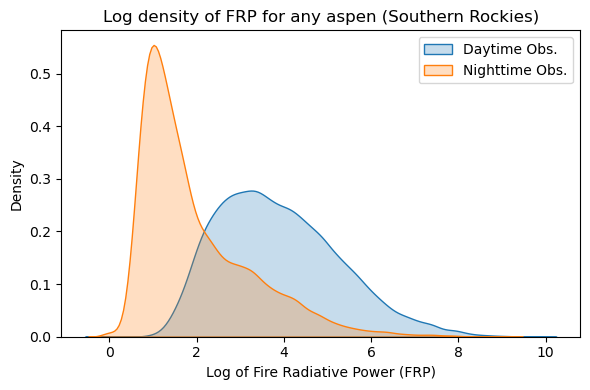

In [70]:
plt.figure(figsize=(6, 4))

frp_plots_aspen_d = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'D']
frp_plots_aspen_n = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'N']

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen_d['FRP']), fill=True, label="Daytime Obs.")
sns.kdeplot(np.log1p(frp_plots_aspen_n['FRP']), fill=True, label="Nighttime Obs.")

# Set plot title and axis labels
plt.title('Log density of FRP for any aspen (Southern Rockies)')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-any_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

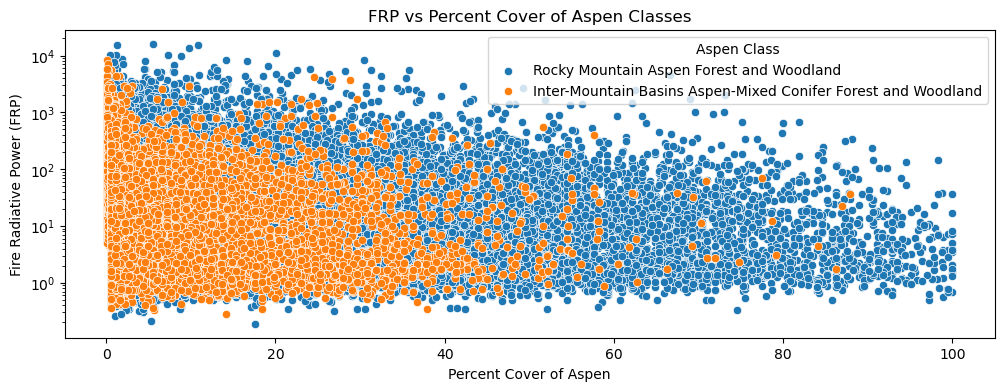

In [75]:
plt.figure(figsize=(12, 4))

frp_plots_aspen_ = frp_evt_srm_aspen[frp_evt_srm_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.yscale('log')

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

In [ ]:
# Identify the dominant EVT types.

In [21]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

,afdID,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
5404,MODIS10000,7051,543.0,1190.0,45.630252,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy
5414,MODIS10003,7051,804.0,1225.0,65.632653,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy
5423,MODIS10004,7051,489.0,1190.0,41.092437,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy
5431,MODIS10027,7016,534.0,1225.0,43.591837,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy
5447,MODIS10028,7016,704.0,1190.0,59.159664,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy


In [23]:
print(f"There are {len(dominant_evt['EVT_GP_N'].unique())} EVT_GP_N categories.\n")
print(dominant_evt['EVT_GP_N'].unique())

There are 55 EVT_GP_N categories.

['Douglas-fir-Ponderosa Pine-Lodgepole Pine Forest and Woodland'
 'Pinyon-Juniper Woodland' 'Spruce-Fir Forest and Woodland'
 'Lodgepole Pine Forest and Woodland'
 'Ponderosa Pine Forest, Woodland and Savanna' 'Deciduous Shrubland'
 'Aspen-Mixed Conifer Forest and Woodland'
 'Aspen Forest, Woodland, and Parkland'
 'Douglas-fir-Grand Fir-White Fir Forest and Woodland' 'Sparse Vegetation'
 'Big Sagebrush Shrubland and Steppe' 'Grassland'
 'Agricultural-Pasture and Hayland' 'Transitional Herbaceous Vegetation'
 'Limber Pine Woodland' 'Conifer-Oak Forest and Woodland'
 'Douglas-fir Forest and Woodland' 'Salt Desert Scrub'
 'Mountain Mahogany Woodland and Shrubland'
 'Agricultural-Close Grown Crop' 'Snow-Ice' 'Dry Tundra'
 'Western Riparian Woodland and Shrubland'
 'Introduced Perennial Grassland and Forbland'
 'Juniper Woodland and Savanna' 'Inland Marshes and Prairies'
 'Transitional Shrub Vegetation' 'Mountain Hemlock Forest and Woodland'
 'Chaparral' '

In [26]:
# Save this file out as well.
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT-dominant.csv')
dominant_evt.to_csv(out_fp)
print(f"Saved zonal statistics to: {out_fp}")

Saved zonal statistics to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT-dominant.csv


In [48]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt = pd.merge(frp, evt, on='afdID', how='left')
frp_evt.head()

,afdID,INSTRUMENT,ACQ_DATETIME,DAYNIGHT,FRP,na_l3name,EVT_NAME,EVT_PHYS,EVT_GP_N,pct_cover
0,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",36.505190
1,MODIS8480,MODIS,2018-06-01 18:15:00+00:00,D,87.1,Southern Rockies,Rocky Mountain Gambel Oak-Mixed Montane Shrubland,Shrubland,Deciduous Shrubland,36.245675
2,MODIS8481,MODIS,2018-06-01 18:15:00+00:00,D,174.5,Southern Rockies,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",53.697479
3,MODIS8482,MODIS,2018-06-01 18:15:00+00:00,D,92.2,Southern Rockies,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,32.179931
4,MODIS8483,MODIS,2018-06-01 18:15:00+00:00,D,235.6,Southern Rockies,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",49.327731


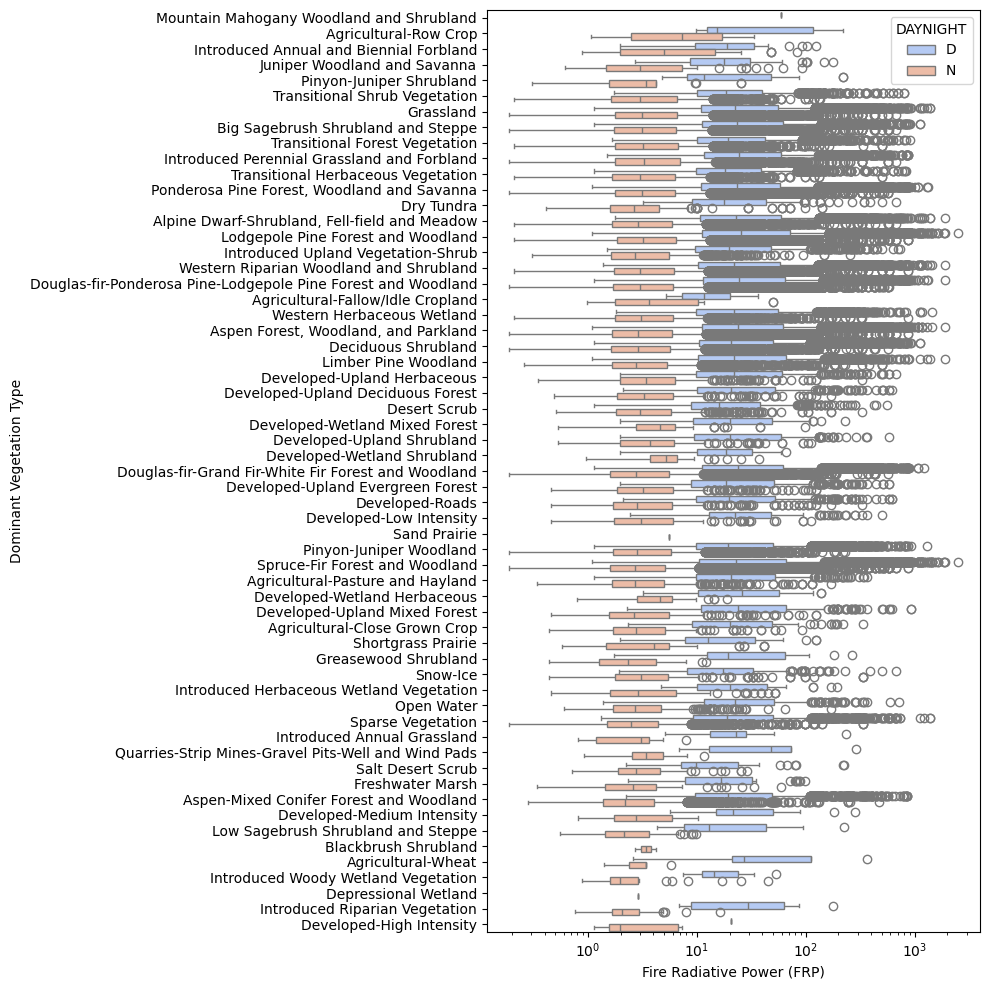

In [77]:
# Plot FRP by EVT group name

df = frp_evt[frp_evt['INSTRUMENT'] == 'VIIRS']

med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

### Calculate the CBD, CBH, and CC from LANDFIRE

Now we calculate zonal statistics for these continuous attributes from LANDFIRE (e.g., mean within the AFD buffer zone).

In [16]:
start = time.time()    

# Read in the LANDFIRE layers
cbd_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBD_200_CONUS/Tif/LC20_CBD_200.tif')
cbh_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBH_200_CONUS/Tif/LC20_CBH_200.tif')
tcc_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CC_200_CONUS/Tif/LC20_CC_200.tif')

lf_paths = [cbd_path, cbh_path, tcc_path]
attrs = ['cbd','cbh','tcc']

results = []
for i in range(len(lf_paths)):
    lf = lf_paths[i]
    attr = attrs[i]
    print(f'Processing {os.path.basename(lf)}')

    # Open the raster data and crop to bounds as before
    lf_da = rxr.open_rasterio(lf, masked=True, cache=False).squeeze()
    lf_da_crop = lf_da.rio.clip_box(
        minx=bounds[0]+1000, # +1000 meters for a small buffer
        miny=bounds[1]+1000, 
        maxx=bounds[2]+1000, 
        maxy=bounds[3]+1000
    )

    if not lf_da_crop.rio.crs == afds.crs:
        print("CRS mismatch, fixing !")
        lf_da_crop = lf_da_crop.rio.reproject(afds.crs)

    del lf_da # clean up
    
    # Calculate the zonal statistics
    zsdf = compute_band_stats(
        geoms=afds, 
        image_da=lf_da_crop, 
        id_col='afdID',
        attr=attr,
        stats=['mean'],
        ztype='continuous'
    )
    
    results.append(zsdf)
    del zsdf

print(f"\nTotal elapsed time: {round((time.time() - start)/60)} minutes")

Processing LC20_CBD_200.tif
Processing LC20_CBH_200.tif
Processing LC20_CC_200.tif
Index(['afdID', 'cbd_mean', 'cbh_mean', 'tcc_mean'], dtype='object')

Total elapsed time: 4 minutes


In [19]:
from functools import reduce
afd_lf_ = reduce(lambda left, right: pd.merge(left, right, on='afdID', how='inner'), results)
afd_lf_.head()

,afdID,cbd_mean,cbh_mean,tcc_mean
0,MODIS7298,5.794958,37.375630,27.504202
1,MODIS7301,1.006531,23.059592,11.493878
2,MODIS7989,13.527731,3.990756,22.840336
3,MODIS7990,7.782007,5.308824,15.160035
4,MODIS7991,12.992215,2.792388,20.337370


In [ ]:
# Join to the percent cover data
